In [1]:
from fastai.vision import *

In [2]:
from torchvision import transforms
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
import utils
from transformer_net import TransformerNet
from vgg import Vgg16

<br>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
bs = 4

In [6]:
tfms = get_transforms()

In [7]:
size = 64

In [8]:
data = (ImageList.from_folder('images/dataset/')
       .split_by_folder(train='train', valid='val')
       .label_from_folder()
       .transform(tfms=tfms, size=size, resize_method=ResizeMethod.CROP)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

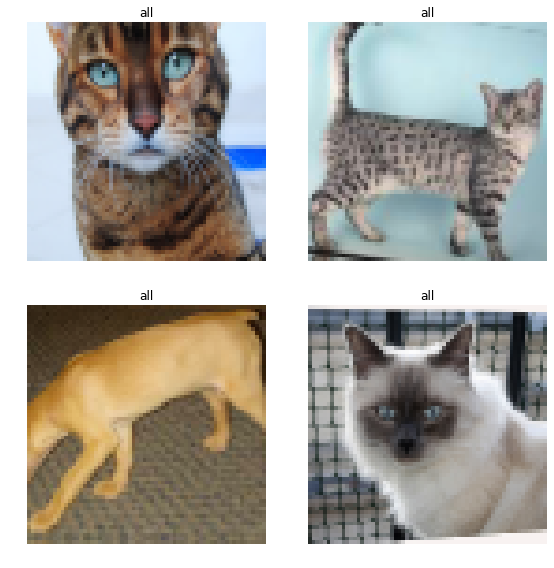

In [9]:
data.show_batch()

In [10]:
style_img = open_image('images/style_images/mosaic.jpg', )

In [11]:
style_img = style_img.apply_tfms(tfms=tfms[1], size=size, resize_method=ResizeMethod.CROP)

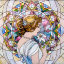

In [13]:
style_img

In [14]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.transformer = TransformerNet()
    
    def forward(self, x):
        y = self.transformer(x)
        
        return x, y

In [15]:
class VggLoss(nn.Module):
    def __init__(self, style_img, content_weight=1e5, style_weight=1e10):
        super().__init__()
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.vgg = Vgg16(requires_grad=False).to(device)
        self.mse = nn.MSELoss()
        
        self.style_img = style_img.apply_tfms(tfms=tfms[1], size=224, resize_method=ResizeMethod.CROP)
        self.style_img = style_img.data.repeat(bs, 1,1,1).to(device)
        self.features_style = self.vgg(self.style_img)#
        self.gram_style = [utils.gram_matrix(x) for x in self.features_style]
        
    
    def forward(self, x, _):
        x, y = x
        features_x = self.vgg(x)
        features_y = self.vgg(y)
        
        content_loss = self.content_weight * self.mse(features_y.relu2_2, features_x.relu2_2)
        
        style_loss = 0.
        for ft_y, gm_s in zip(features_y, self.gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += self.mse(gm_y, gm_s[:, :, :])
        style_loss *= self.style_weight
        
        return content_loss + style_loss

In [16]:
model = MyModel()

In [17]:
loss = VggLoss(style_img)

<br>

In [18]:
learner = Learner(data, model, loss_func=loss)

In [21]:
learner.lr_find(start_lr=1e-05, end_lr=1e-01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


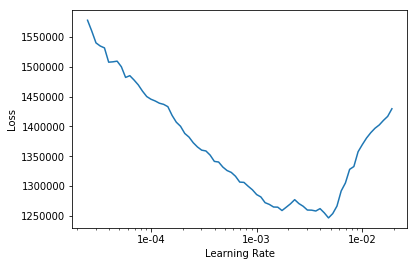

In [29]:
learner.recorder.plot()